<a href="https://colab.research.google.com/github/mernaa214/Facial-Emotions-Recognition/blob/main/Facial_Emotions_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uibhjbh\
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset


100%|██████████| 60.7M/60.7M [00:00<00:00, 1.36GB/s]

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# **Load the Dataset**

In [ ]:
TRAIN_DIR = '/content/facial-expression-dataset/train/train/'
TEST_DIR = '/content/facial-expression-dataset/test/test/'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
# Example result: /content/facial-expression-dataset/train/angry/0001.png.
        print(label, "Completed")

    return image_paths, labels

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

sad Completed
fear Completed
surprise Completed
angry Completed
disgust Completed
neutral Completed
happy Completed


,image,label
0,/content/facial-expression-dataset/train/train...,surprise
1,/content/facial-expression-dataset/train/train...,fear
2,/content/facial-expression-dataset/train/train...,angry
3,/content/facial-expression-dataset/train/train...,neutral
4,/content/facial-expression-dataset/train/train...,happy


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

sad Completed
fear Completed
surprise Completed
angry Completed
disgust Completed
neutral Completed
happy Completed


,image,label
0,/content/facial-expression-dataset/test/test/s...,sad
1,/content/facial-expression-dataset/test/test/s...,sad
2,/content/facial-expression-dataset/test/test/s...,sad
3,/content/facial-expression-dataset/test/test/s...,sad
4,/content/facial-expression-dataset/test/test/s...,sad


# **Exploratory Data Analysis**

<Axes: xlabel='count', ylabel='label'>

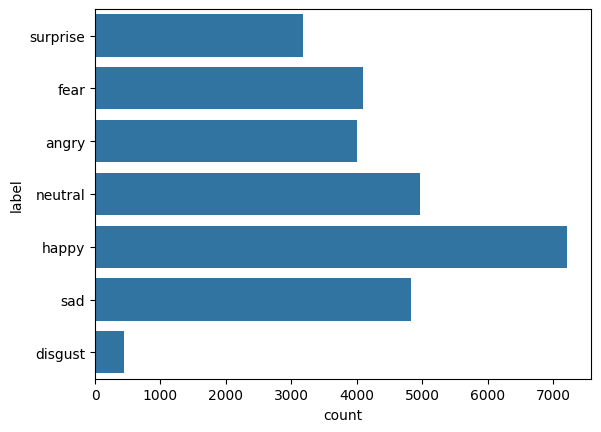

In [ ]:
sns.countplot(train['label'])

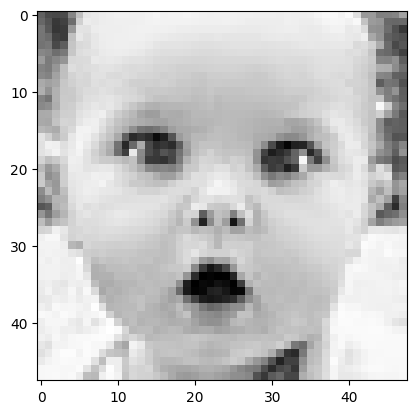

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

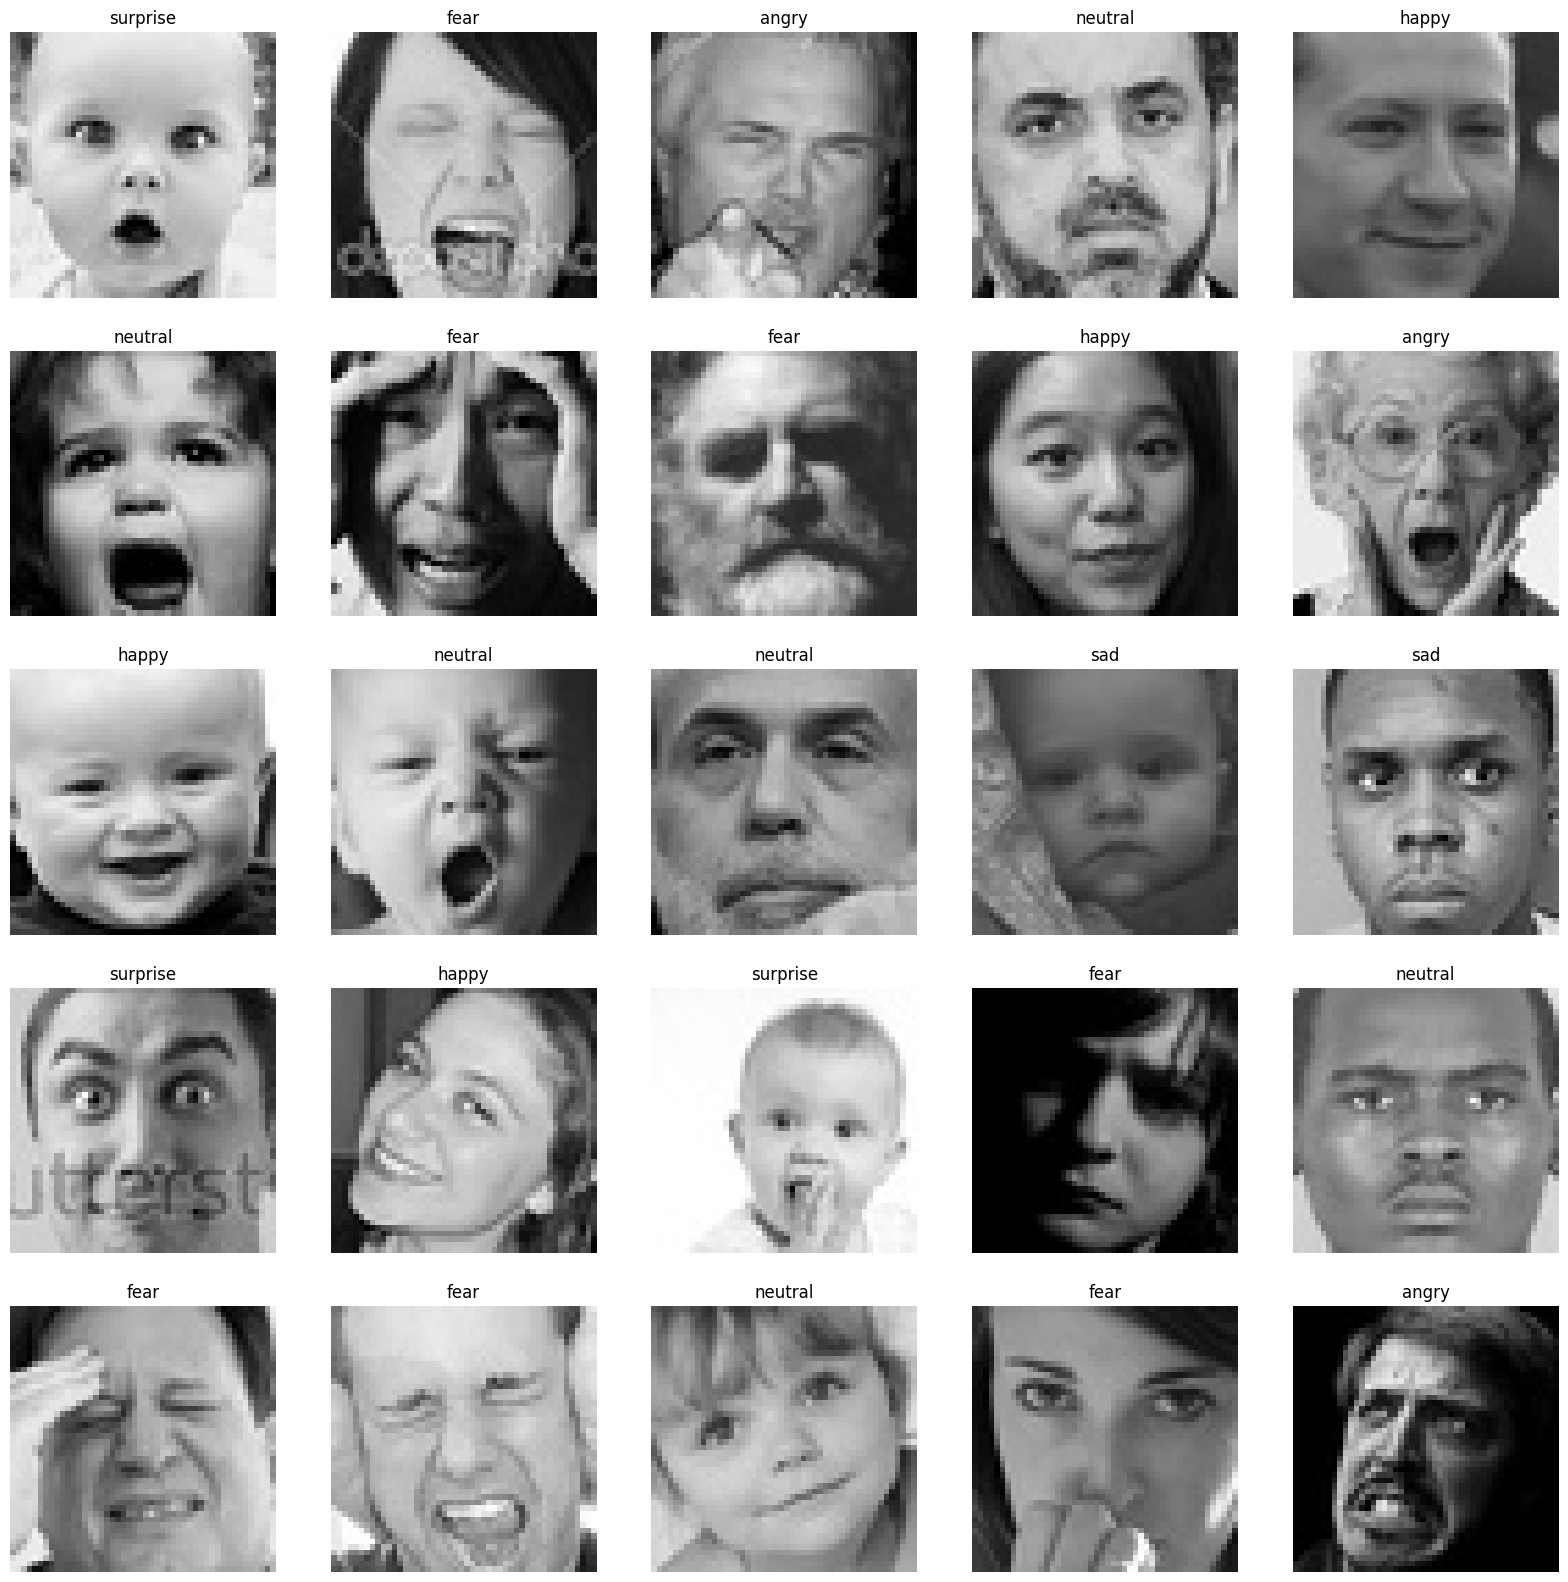

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# **Preprocessing "Feature Extraction"**

In [ ]:
# feature extraction means transforming raw data into a form that machine learning models can understand.
# 📂 Image File → 🖼 Matrix of pixel intensities → 📊 NumPy array shaped for model input.

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale" ) #ERROR -> (grayscale=True) so we replaced it with color_mode
        img = np.array(img)
        features.append(img)
# The "features" = pixel intensity values in a structured NumPy array.
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
# Inside the function:
# Each image path is read with load_img().
# Converted to grayscale (48x48).
# Stored into a NumPy array.
# Final shape after all images: (28709, 48, 48, 1)
# 28,709 images, each stored as a 48x48 grayscale matrix with 1 channel.
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
# Your labels are 4D (28709, 7, 7, 7) - (7178, 7, 7, 7) instead of the correct 2D (28709, 7), (7178, 7)
# That means you accidentally applied to_categorical (or reshaping) multiple times, expanding the dimensions at each step, So we reshaped it.

y_train = y_train.reshape(-1, 7)
y_test = y_test.reshape(-1, 7)
print(y_train.shape)  # (num_samples, 7)
print(y_test.shape)   # (num_samples, 7)

(28709, 7)
(7178, 7)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.])

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

---
# **Model Creation**
---

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # metrics='accuracy' ERROR

In [ ]:
# train the model

# ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 7, 7), output.shape=(None, 7)
# Your labels y_train and y_test don’t have the right shape compared to your model’s output layer (our labels (y_train) → (None, 7, 7) ❌ (extra dimension))
# That means your one-hot encoding went wrong — you probably applied to_categorical twice or reshaped incorrectly.
# So I repaired it using reshape in cell 66

history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.2356 - loss: 1.8371 - val_accuracy: 0.2484 - val_loss: 1.8101
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.2493 - loss: 1.8047 - val_accuracy: 0.2623 - val_loss: 1.7797
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.2683 - loss: 1.7581 - val_accuracy: 0.3413 - val_loss: 1.6575
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.3322 - loss: 1.6590 - val_accuracy: 0.4395 - val_loss: 1.4688
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.3974 - loss: 1.5414 - val_accuracy: 0.4649 - val_loss: 1.3846
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4312 - loss: 1.4741 - val_accuracy: 0.4752 - val_loss: 1.3581
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4451 - loss: 1.4287 - val_accuracy: 0.4974 - val_loss: 1.2935
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4728 - loss: 1

# **Plot the Results**

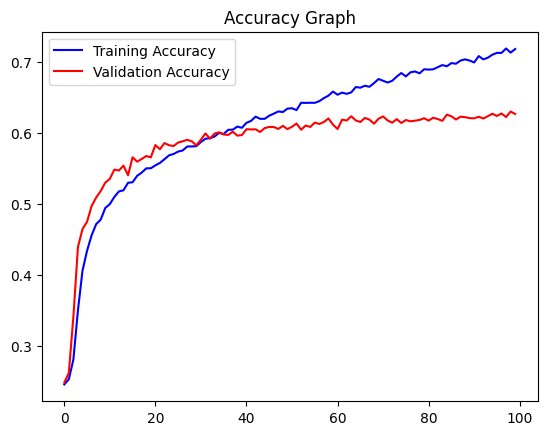

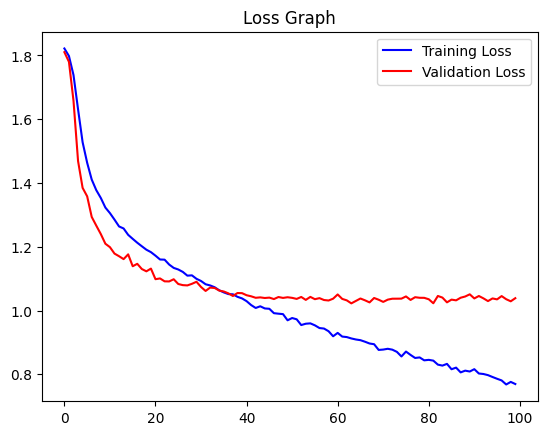

In [ ]:
# Now we will display a few random images with its label and predict the output
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

# **Test with Image Data**

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Output: happy


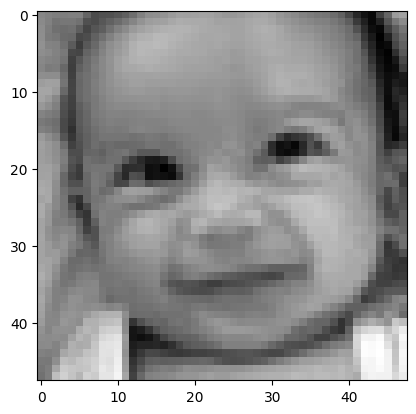

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

# **Final Thoughts**


* **Training the model by increasing the no. of epochs can give better and more accurate results.**

* **Processing large amount of data can take a lot of time and system resources.**

* **Basic deep learning model trained in a neural network, adding new layers varies the results.**

*   **In this project tutorial, we have explored the Facial Emotion Recognition as a image classification project. This is a basic deep learning project to learn image classification and visualize the results through different plots.**








